# Evaluando la mejor ventana de predicción

Se quiere saber qué tan bien predice el modelo a medida que la ventana de predicción se hace mayor. Hasta el momento sólo se sabe que el modelo tiene una buena predicción para la hora siguiente.

Se importan las librerías.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM

Se importa el mejor modelo

In [ ]:
model = keras.models.load_model('./drive/MyDrive/DatosInvestigacion/RSG_model.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 75)                23100     
                                                                 
 dense (Dense)               (None, 1)                 76        
                                                                 
Total params: 23,176
Trainable params: 23,176
Non-trainable params: 0
_________________________________________________________________


El modelo necesita los datos de las últimas 22 horas.

In [ ]:
n_input=22
n_features = 0

Se importan los datos de entrenamiento y prueba.

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')
df = df.between_time('08:00:00','17:00:00')
df = df[['SRGLOAVG1H','TAMAX1H','TAMIN1H','WS1HX','WS1HA','RHMIN1H','RHMAX1H']]


In [ ]:
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')
df_test = df_test[['SRGLOAVG1H','TAMAX1H','TAMIN1H','WS1HX','WS1HA','RHMIN1H','RHMAX1H']]
df_test = df_test.between_time('08:00:00','17:00:00')

In [ ]:
RSG = df['SRGLOAVG1H'].values
RSG = np.reshape(RSG,(-1,1))
RSG_test = df_test['SRGLOAVG1H'].values
RSG_test = np.reshape(RSG_test,(-1,1))

Se normalizan los datos.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(RSG)
scaled_train = scaler.transform(RSG)
scaled_test = scaler.transform(RSG_test)

De esta forma se puede predecir la hora siguiente en todo el dataset de prueba.

In [ ]:
predictions = []
for j in range(n_input,len(df_test)):
  model_input = scaled_test[j-n_input:j]
  model_input = model_input.reshape((1, n_input, n_features+1))
  predictions.append(model.predict(model_input)[0])
predictions = np.ndarray.flatten(np.array(predictions))  
true_predictions = scaler.inverse_transform(np.reshape(predictions,(-1,1)))
true_values = np.ndarray.flatten(df_test.iloc[n_input:]['SRGLOAVG1H'].values)
errorMSE = mean_squared_error(true_values,true_predictions)
errorMAE = mean_absolute_error(true_values,true_predictions)

Se obtienen los errores de las predicciones.

In [ ]:
errorMAE

128.46700768610035

In [ ]:
errorMSE**(1/2)

164.04970448822036

Se requiere de un blucle extra para predecir más de una hora.

In [ ]:
ventana=2

In [ ]:
test_predictions = []
true_values = []
first_eval_batch = scaled_test[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features+1))

for i in range(ventana):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    true_values.append(RSG_test[n_input+i])

In [ ]:
true_predictions = scaler.inverse_transform(np.reshape(test_predictions,(-1,1)))

In [ ]:
RSG_test[n_input:n_input+ventana]

array([[376.],
       [700.]])

In [ ]:
true_values

[array([376.]), array([700.])]

In [ ]:
true_predictions

array([[583.85754],
       [587.4029 ]], dtype=float32)

Ahora se recorre todo el conjunto de pruebas con un valor de ventana de predicción mayor a 1.

In [ ]:
ventana=2

In [ ]:
predictions = []
true_values = []
for j in range(n_input,len(df_test)-ventana):
  first_eval_batch = scaled_test[j-n_input:j]
  current_batch = first_eval_batch.reshape((1, n_input, n_features+1))
  for i in range(ventana):
      current_pred = model.predict(current_batch)[0]
      # guardar la predicción
      predictions.append(current_pred) 
      # actualizar el lote para incluir ahora la predicción y soltar primer valor
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
      true_values.append(RSG_test[j+i])
true_predictions = scaler.inverse_transform(np.reshape(predictions,(-1,1)))

In [ ]:
true_values[:5]

[array([376.]), array([700.]), array([700.]), array([665.]), array([665.])]

In [ ]:
true_predictions[:5]

array([[583.85754],
       [587.4029 ],
       [424.48642],
       [512.0769 ],
       [699.3955 ]], dtype=float32)

In [ ]:
errorMSE = mean_squared_error(true_values,true_predictions)
errorMAE = mean_absolute_error(true_values,true_predictions)

In [ ]:
errorMAE

144.68448880123893

In [ ]:
errorMSE**(1/2)

183.5461698469602

In [ ]:
resultados = []

Se crea un último bucle para incrementar el tamaño de la ventana de predicción.

In [ ]:
for ventana in range(31,33):
  predictions = []
  true_values = []
  print('Ventana:',ventana)
  for j in range(n_input,len(df_test)-ventana):
    first_eval_batch = scaled_test[j-n_input:j]
    current_batch = first_eval_batch.reshape((1, n_input, n_features+1))
    for i in range(ventana):
        current_pred = model.predict(current_batch)[0]
        # guardar la predicción
        predictions.append(current_pred) 
        # actualizar el lote para incluir ahora la predicción y soltar primer valor
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        true_values.append(RSG_test[j+i])
  true_predictions = scaler.inverse_transform(np.reshape(predictions,(-1,1)))
  errorMSE = mean_squared_error(true_values,true_predictions)
  errorMAE = mean_absolute_error(true_values,true_predictions)  
  resultados.append({
      'Ventana':ventana,
      'MAE':errorMAE,
      'RMSE':np.sqrt(errorMSE)
  })
  print(resultados[-1:])

Ventana: 31
[{'Ventana': 31, 'MAE': 191.38712928653553, 'MSE': 241.6641313653061}]
Ventana: 32
[{'Ventana': 32, 'MAE': 191.91656063223633, 'MSE': 242.3379253775286}]


In [ ]:
resultados[:2]

[{'MAE': 191.38712928653553, 'MSE': 241.6641313653061, 'Ventana': 31},
 {'MAE': 191.91656063223633, 'MSE': 242.3379253775286, 'Ventana': 32}]

In [ ]:
resultados = pd.DataFrame(resultados)

Se guardan los resultados como csv

In [16]:
resultados.to_csv('./drive/MyDrive/DatosInvestigacion/resultados_prediccion.csv',index=False)

In [17]:
resultados = pd.read_csv('./drive/MyDrive/DatosInvestigacion/resultados_prediccion.csv')

Se tiene un RMSE menor a 200 sólo en las primeras 3 horas de predicción.

In [18]:
resultados.head()

,Ventana,RMSE,MAE
0,1,164.102554,128.525358
1,2,183.546170,144.684489
2,3,195.036732,153.849718
3,4,202.413374,159.817385
4,5,207.319242,163.831378


Se puede ver el crecimiento del error.

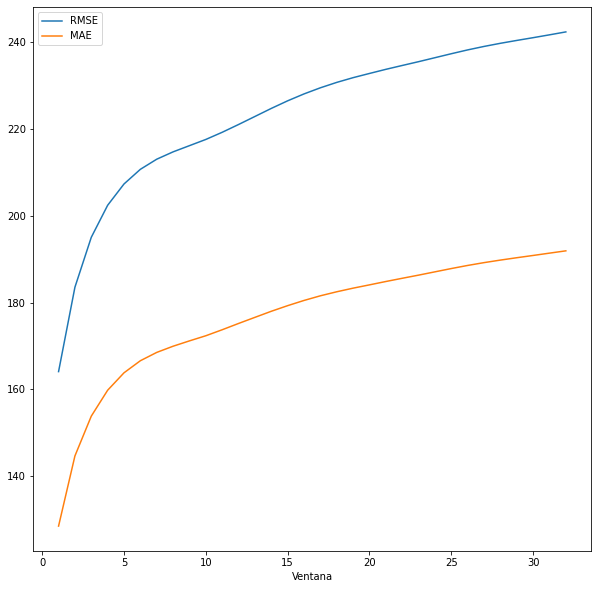

In [15]:
resultados.plot(x='Ventana',figsize=(10,10))